## Model Training

In [ ]:
!pip install tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 91.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting unin

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import glob
import cv2, random
import numpy as np

from tqdm.keras import TqdmCallback
from tensorflow.keras.layers import BatchNormalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class Generator(tf.keras.utils.Sequence):

    def __init__(self, train_dir='/content/drive/MyDrive/denso', genType='train', input_size = 224, shuffle=True):
        self.shuffle = shuffle
        self.genType = genType
        self.train_ratio = 0.80

        self.epoch       = 0
        self.batch_size  = 32
        self.dim = (input_size, input_size)

        #Kernel 5 20 40 60 80 100
        self.ksize = [5, 7, 15, 25, 49, 81, 121]
        self.qual  = [.95, .9, .80, .60, .40, .20, 0.0]
        files = glob.glob(os.path.join(train_dir, "*.*"))
        tmp_idx =int(self.train_ratio*len(files))

        if genType == 'train' :
            self.files = files[0:tmp_idx]
        else :
            self.files = files[tmp_idx:]

        print (len(self.files))

        self.len = self.__len__()    #an attribute for the length

        if self.genType != 'test' :
            self.on_epoch_end()


    # ==================================
    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return (2*len(self.files)) // self.batch_size

    # ==================================
    def blur(self, img) :
        k_index=random.randint(0,5)
        type =random.randint(0,2)

        i = self.ksize[k_index]
        if type == 2 :
            blurimg = cv2.GaussianBlur(img,(i,i),0)
        elif type == 1:
            blurimg = cv2.medianBlur(img,i)
        else:
            blurimg = cv2.blur(img, (i,i))

        return blurimg, self.qual[k_index]

    # ==================================
    def on_epoch_end(self):
        if self.shuffle and self.genType != 'test' :
            random.shuffle(self.files)
        self.epoch += 1


    # ==================================
    def __getitem__(self, index):
        # Generate
        data_list = []
        labels = []

        # Get next batch/2 files
        for f in self.files[index*self.batch_size//2:(index+1)*self.batch_size//2]:
            img = cv2.imread(f)
            img = cv2.resize(img, self.dim)
            blur_img, val = self.blur(img)

            data_list.append(img)
            data_list.append(blur_img)

            labels.append(1.0)
            labels.append(val)

        data_list = np.array(data_list)
        labels = np.array(labels)

        return data_list, labels

In [ ]:
#EfficientNetB0 	224
#EfficientNetB1 	240
#EfficientNetB2 	260
#EfficientNetB3 	300
#EfficientNetB4 	380
#EfficientNetB5 	456
#EfficientNetB6 	528
#EfficientNetB7 	600
eff_image_sizes = [224, 240, 260, 300, 380, 456, 528, 600]
efficientNetMode = 5 # 0-7 for valid value, -1 for invalid value
if efficientNetMode == -1:
    input_size = 512
else :
    input_size = eff_image_sizes[efficientNetMode]

train_generator = Generator(genType='train', input_size=input_size, shuffle=True)
val_generator   = Generator(genType='val', input_size=input_size, shuffle=True)
print (train_generator.__len__())
print (val_generator.__len__())
for i in range (val_generator.__len__()) :
    tmp2, tmp1 = val_generator.__getitem__(i)
    print (i, ": ", tmp1.shape, tmp2.shape)
    break

for i in range (train_generator.__len__()) :
    tmp2, tmp1 = train_generator.__getitem__(i)
    print (i, ": ", tmp1.shape, tmp2.shape)
    break


1524
381
95
23
0 :  (32,) (32, 456, 456, 3)
0 :  (32,) (32, 456, 456, 3)


In [ ]:
if efficientNetMode == -1:
    input = tf.keras.Input(shape=(input_size, input_size, 3))

    # Few iterations to try
    # Change filters and kernal sizes

    x = layers.Conv2D(128, 5, 5)(input)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization(axis=-1)(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(256, 3, 3)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization(axis=-1)(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, 3, 3)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization(axis=-1)(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    output = layers.Dense(1, activation="linear")(x)

    model = Model(input, output)
else :
    assert efficientNetMode <= 7 and efficientNetMode >= 0

    if   efficientNetMode == 0 : from tensorflow.keras.applications import EfficientNetB0 as efficientNet
    elif efficientNetMode == 1 : from tensorflow.keras.applications import EfficientNetB1 as efficientNet
    elif efficientNetMode == 2 : from tensorflow.keras.applications import EfficientNetB2 as efficientNet
    elif efficientNetMode == 3 : from tensorflow.keras.applications import EfficientNetB3 as efficientNet
    elif efficientNetMode == 4 : from tensorflow.keras.applications import EfficientNetB4 as efficientNet
    elif efficientNetMode == 5 : from tensorflow.keras.applications import EfficientNetB5 as efficientNet
    elif efficientNetMode == 7 : from tensorflow.keras.applications import EfficientNetB7 as efficientNet
    elif efficientNetMode == 6 : from tensorflow.keras.applications import EfficientNetB6 as efficientNet

    input = tf.keras.Input(shape=(input_size, input_size, 3))

    model_int = efficientNet(include_top=False, input_tensor=input, weights='imagenet', drop_connect_rate=0.2)

    # Freeze the pretrained weights

    print ("Freezing Backend ... ")
    model_int.trainable = False

    #for i in range(len(efficientNet.layers)-20):
    #    efficientNet.layers[i].trainable = False
    num_nonfreeze = 4
    for layer in model_int.layers[-num_nonfreeze:] :
        if not isinstance(layer, BatchNormalization) :
            layer.trainable = True
        else :
            layer.trainable = False

    #model_int.summary()

    # Rebuild top
    x = model_int.output
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    #output = layers.Dense(5, activation="softmax", name="pred")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2, name="top_dropout")(x)

    x = layers.Dense(64, activation="relu")(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    output = layers.Dense(1, activation="linear")(x)

    # Compile
    model = Model(input, output, name="EfficientNet")

print (model.summary())

115263384/115263384 [==============================] - 1s 0us/step
Freezing Backend ... 
Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 456, 456, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 456, 456, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 456, 456, 3)  7           ['rescaling[0][0]']              
                                                                                                 

In [ ]:

model.compile(tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-3 / 200), #tf.keras.optimizers.rmsprop(lr=0.0001, decay=1e-6),
                    loss='mean_squared_error',
                    metrics=['accuracy'])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                os.path.join('drive','MyDrive','densotrain'
                    'checkpoints',
                    'blur_{epoch:02d}_{loss:.4f}_{val_loss:.4f}.h5'
                ),
                verbose=0,
                save_best_only=True
            )

model.fit(train_generator,
          validation_data = val_generator,
          #steps_per_epoch = num_steps_per_epoch,
          #initial_epoch = 160,
          epochs = 80,
          verbose=1,
          callbacks=[checkpoint, TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

Epoch 1/80
95/95 [==============================] - 102s 1s/step - loss: 0.5961 - accuracy: 0.4184 - val_loss: 0.1617 - val_accuracy: 0.3899
Epoch 2/80
95/95 [==============================] - 102s 1s/step - loss: 0.2707 - accuracy: 0.4701 - val_loss: 0.0824 - val_accuracy: 0.5082
Epoch 3/80
95/95 [==============================] - 101s 1s/step - loss: 0.1573 - accuracy: 0.5230 - val_loss: 0.0578 - val_accuracy: 0.5584
Epoch 4/80
95/95 [==============================] - 102s 1s/step - loss: 0.1160 - accuracy: 0.5368 - val_loss: 0.0352 - val_accuracy: 0.5720
Epoch 5/80
95/95 [==============================] - 102s 1s/step - loss: 0.0771 - accuracy: 0.5556 - val_loss: 0.0239 - val_accuracy: 0.5883
Epoch 6/80
95/95 [==============================] - 102s 1s/step - loss: 0.0597 - accuracy: 0.5648 - val_loss: 0.0206 - val_accuracy: 0.5897
Epoch 7/80
95/95 [==============================] - 102s 1s/step - loss: 0.0467 - accuracy: 0.5743 - val_loss: 0.0188 - val_accuracy: 0.5815
Epoch 8/80
95

In [ ]:
model.save("/content/drive/MyDrive/densotrain/denso_80_efficient5.h5")

KeyboardInterrupt: ignored

## Model inference


In [ ]:
model.load_weights('/content/drive/MyDrive/densotraincheckpoints/blur_23_0.0128_0.0039.h5')

In [ ]:
image = cv2.imread('/content/drive/MyDrive/denso/10_jpg.rf.77c1d855a9284b9cd0af6127a5df18cc.jpg')
image = cv2.resize(image, (456,456))
image.shape

(456, 456, 3)

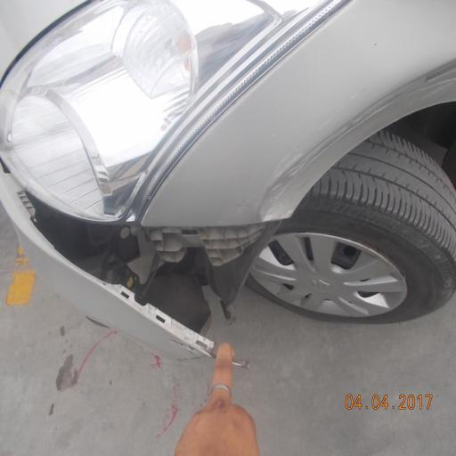

1/1 [==============================] - 0s 52ms/step
[[1.0745122]]


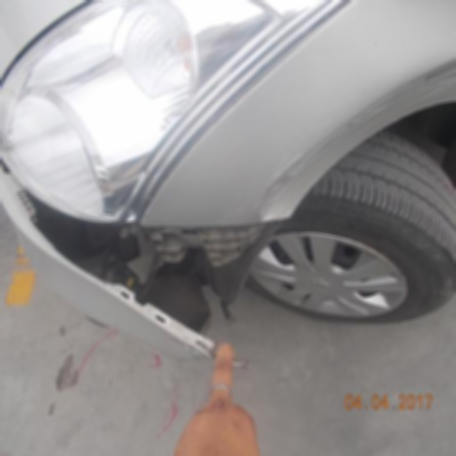

1/1 [==============================] - 0s 43ms/step
[[0.8918803]]


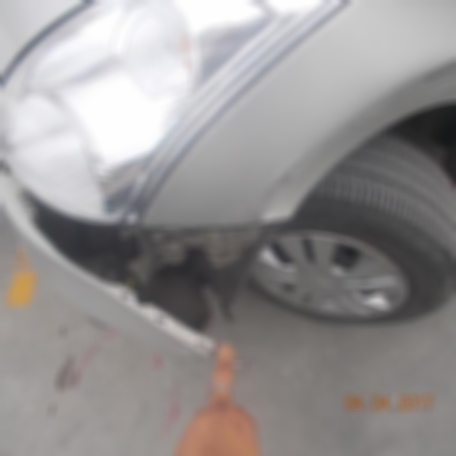

1/1 [==============================] - 0s 45ms/step
[[0.83751583]]


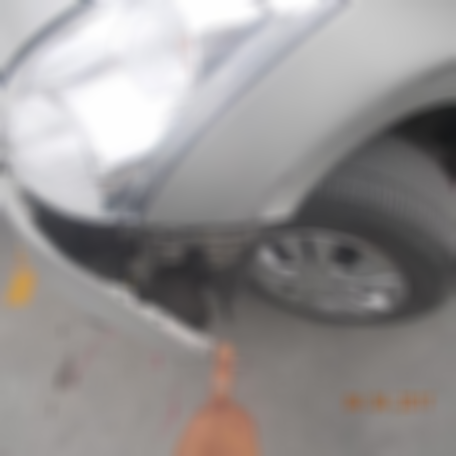

1/1 [==============================] - 0s 43ms/step
[[0.6964308]]


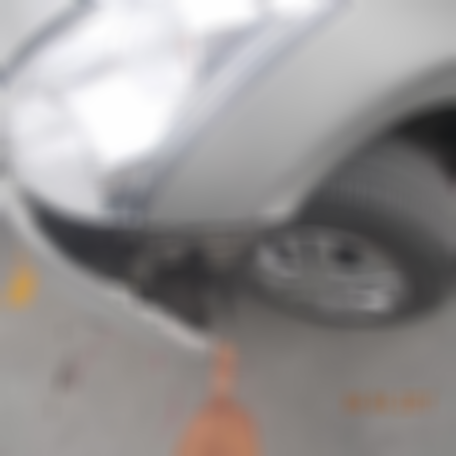

1/1 [==============================] - 0s 50ms/step
[[0.62177575]]


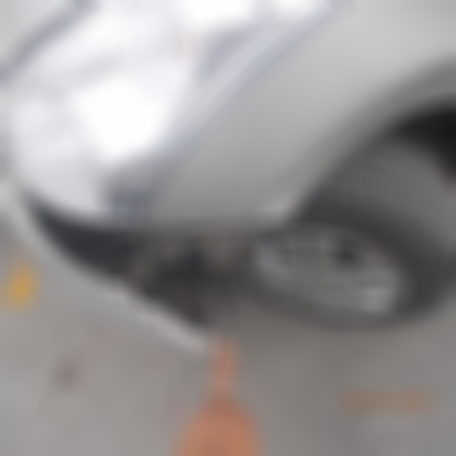

1/1 [==============================] - 0s 46ms/step
[[0.5281879]]


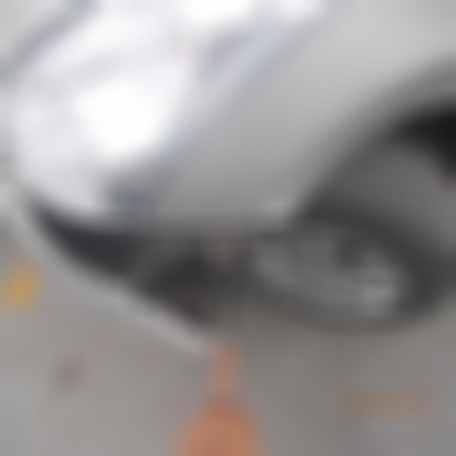

1/1 [==============================] - 0s 44ms/step
[[0.440764]]


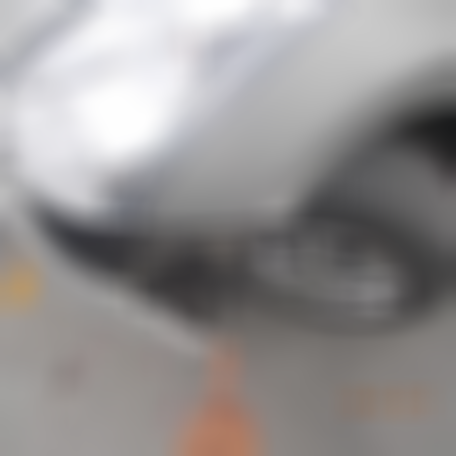

1/1 [==============================] - 0s 44ms/step
[[0.36241794]]


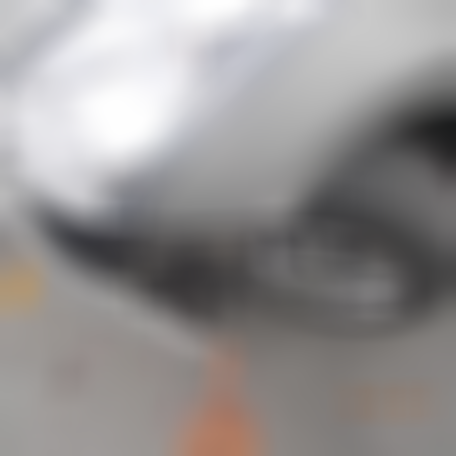

1/1 [==============================] - 0s 46ms/step
[[0.32193708]]


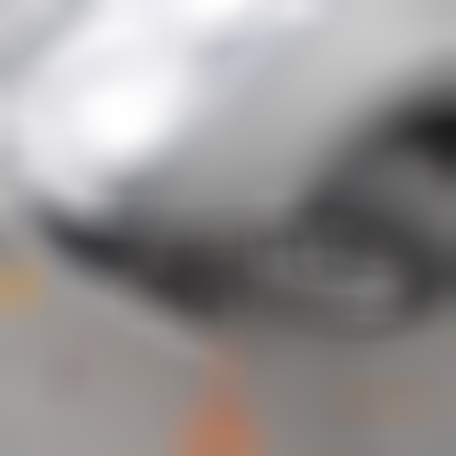

1/1 [==============================] - 0s 46ms/step
[[0.25343215]]


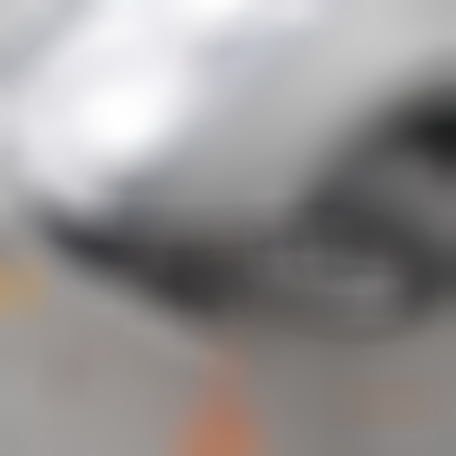

1/1 [==============================] - 0s 44ms/step
[[0.19852409]]


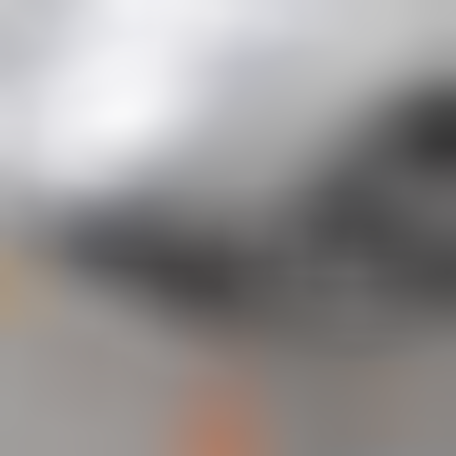

1/1 [==============================] - 0s 103ms/step
[[0.03600311]]


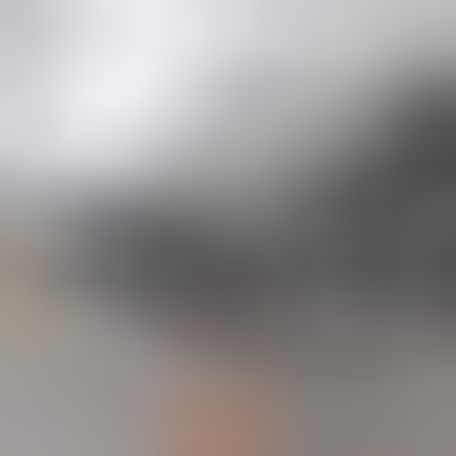

1/1 [==============================] - 0s 50ms/step
[[0.02306083]]


In [ ]:
ksize = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49, 81, 121]
from google.colab.patches import cv2_imshow
import numpy as np
for ker in ksize:
  blur_im = cv2.blur(image,(ker,ker))
  cv2_imshow(blur_im)
  blur_im = blur_im[np.newaxis,:]

  print(model.predict(blur_im))